# **Mildew Detector for Cherry Trees**

## Objectives

* Fetch data from Kaggle and prepare it for further ML processing.

## Inputs

* Kaggle.json file -authentication token

## Outputs

* Generate Dataset: inputs/datasets/cherry_leaves

## Additional Comments
 



No comments

---

# Change working directory

In [8]:
import numpy
import os
from pathlib import Path


Change the working directory

In [9]:
current_dir = os.getcwd()
current_dir

'/workspace/NEW-CHERRY-LEAVES'

In [10]:
os.chdir('/workspace/NEW-CHERRY-LEAVES')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [11]:
current_dir = os.getcwd()
current_dir

'/workspace/NEW-CHERRY-LEAVES'

# Install Kaggle

Section 1 content

In [12]:
# Install Kaggle package
!pip install kaggle 

  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105839 sha256=0d8cbbfbbbc4c5fe286bddf243125aa9313947e9cdc0b2a3bd232e15e970d09d
  Stored in directory: /home/gitpod/.cache/pip/wheels/46/d2/26/84d0a1acdb9c6baccf7d28cf06962ec80529fe1ad938489983
Successfully built kaggle


---

Change the Kaggle configuration directory to current working directory and permission of Kaggle authentication json.

In [13]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
! chmod 600 kaggle.json

chmod: cannot access 'kaggle.json': No such file or directory


Set Kaggle Dataset and download it.

In [14]:
KaggleDatasetPath = "codeinstitute/cherry-leaves"
DestinationFolder = "inputs/cherry_leaves"
! kaggle datasets download -d {KaggleDatasetPath} -p {DestinationFolder}


Dataset URL: https://www.kaggle.com/datasets/codeinstitute/cherry-leaves
License(s): unknown
 96%|████████████████████████████████████▌ | 53.0M/55.0M [00:02<00:00, 34.1MB/s]
100%|██████████████████████████████████████| 55.0M/55.0M [00:02<00:00, 25.2MB/s]


Unzip the downloaded file, and delete the zip file.

In [15]:
import zipfile
with zipfile.ZipFile(DestinationFolder + '/cherry-leaves.zip', 'r') as zip_ref:
    zip_ref.extractall(DestinationFolder)

os.remove(DestinationFolder + '/cherry-leaves.zip')

# Data Preparation

Check and Remove non-image files

---

In [16]:

def remove_non_image_file(my_data_dir):
    image_extension = ('.png', '.jpg', '.jpeg')
    folders = os.listdir(my_data_dir)
    for folder in folders:
        files = os.listdir(my_data_dir + '/' + folder)
        # print(files)
        i = []
        j = []
        for given_file in files:
            if not given_file.lower().endswith(image_extension):
                file_location = my_data_dir + '/' + folder + '/' + given_file
                os.remove(file_location)  # remove non image file
                i.append(1)
            else:
                j.append(1)
                pass
        print(f"Folder: {folder} - has image file", len(j))
        print(f"Folder: {folder} - has non-image file", len(i))

In [17]:
remove_non_image_file(my_data_dir='inputs/cherry_leaves/cherry-leaves')

Folder: healthy - has image file 2104
Folder: healthy - has non-image file 0
Folder: powdery_mildew - has image file 2104
Folder: powdery_mildew - has non-image file 0


### Check for corrupted images

In [18]:
import os
from PIL import Image

#### Define the dataset directory

In [19]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'

Initialize list to track corrupted images and iterate through the dataset to check for corrupted images.

In [20]:
corrupted_files = []

# Iterate through the dataset to check for corrupted images
print("Checking for corrupted images...")
for root, _, files in os.walk(my_data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            # Try opening the image to detect corruption
            with Image.open(file_path) as img:
                img.verify()
        except (FileNotFoundError, OSError):
            corrupted_files.append(file_path)

Checking for corrupted images...


Log the results

In [28]:
if corrupted_files:
    print("Corrupted files detected:")
    for file in corrupted_files:
        print(file)
else:
    print("No corrupted files found.")

# Save results to a text file
with open("corrupted_files_log.txt", "w") as log_file:
    if corrupted_files:
        log_file.write("Corrupted files:\n")
        log_file.writelines([f"{file}\n" for file in corrupted_files])

print("Check completed. Results logged to corrupted_files_log.txt")


No corrupted files found.
Check completed. Results logged to corrupted_files_log.txt


Split train validation set

In [22]:
import os
import shutil
import random

def split_train_validation_test_images(my_data_dir, train_set_ratio, validation_set_ratio, test_set_ratio):
    """
    Split the dataset of images into train, validation, and test sets.

    Args:
        my_data_dir (str): Path to the dataset directory containing class folders.
        train_set_ratio (float): Proportion of data to be used for training.
        validation_set_ratio (float): Proportion of data to be used for validation.
        test_set_ratio (float): Proportion of data to be used for testing.

    Returns:
        None
    """
    # Check if ratios sum to 1.0
    if not abs(train_set_ratio + validation_set_ratio + test_set_ratio - 1.0) < 1e-6:
        raise ValueError("train_set_ratio, validation_set_ratio, and test_set_ratio should sum to 1.0.")

    # Get class labels (folder names)
    labels = [label for label in os.listdir(my_data_dir) if os.path.isdir(os.path.join(my_data_dir, label))]

    # Create train, validation, test directories
    for folder in ['train', 'validation', 'test']:
        for label in labels:
            os.makedirs(os.path.join(my_data_dir, folder, label), exist_ok=True)

    for label in labels:
        class_dir = os.path.join(my_data_dir, label)
        files = [file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))]
        random.shuffle(files)

        # Calculate split indices
        train_count = int(len(files) * train_set_ratio)
        val_count = int(len(files) * validation_set_ratio)
        
        train_files = files[:train_count]
        val_files = files[train_count:train_count + val_count]
        test_files = files[train_count + val_count:]

        # Move files to corresponding folders
        for file in train_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(my_data_dir, 'train', label, file))

        for file in val_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(my_data_dir, 'validation', label, file))

        for file in test_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(my_data_dir, 'test', label, file))

        # Remove the original class folder if empty
        if not os.listdir(class_dir):
            os.rmdir(class_dir)

    print("Data successfully split into train, validation, and test sets.")
    

In [23]:
split_train_validation_test_images(my_data_dir = f"inputs/cherry_leaves/cherry-leaves",
                        train_set_ratio = 0.7,
                        validation_set_ratio=0.1,
                        test_set_ratio=0.2
                        )

Data successfully split into train, validation, and test sets.


Verify class balance in training set

Load Dataset

In [24]:
import os

# Path to the training set
train_dir = "inputs/cherry_leaves/cherry-leaves/train"

# Count and plot for training set only
train_classes = os.listdir(train_dir)
train_class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in train_classes}

print("Training Set Class Distribution:", train_class_counts)


Training Set Class Distribution: {'healthy': 1472, 'powdery_mildew': 1472}


Visualise Class Distribution

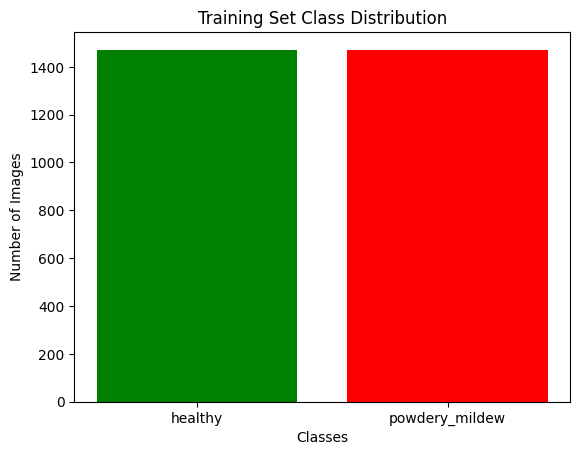

In [25]:
import matplotlib.pyplot as plt

# Bar chart for class distribution
plt.bar(train_class_counts.keys(), train_class_counts.values(), color=['green', 'red'])
plt.title('Training Set Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()


Check the validation set - Just to be aware of any natural inconsistencies or huge imbalances. This check will be used when the data set increases with more species and images.

In [26]:
# Path to the validation set
validation_dir = "inputs/cherry_leaves/cherry-leaves/validation"

# Count and plot for validation set
validation_classes = os.listdir(validation_dir)
validation_class_counts = {cls: len(os.listdir(os.path.join(validation_dir, cls))) for cls in validation_classes}

print("Validation Set Class Distribution:", validation_class_counts)


Validation Set Class Distribution: {'healthy': 210, 'powdery_mildew': 210}


---

# Conclusions and Next Steps

* conclusions and next steps. FINISH
